__Just as naive Bayes is a good starting point for classification tasks, linear regression models area good starting point for regression tasks.__

In [2]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

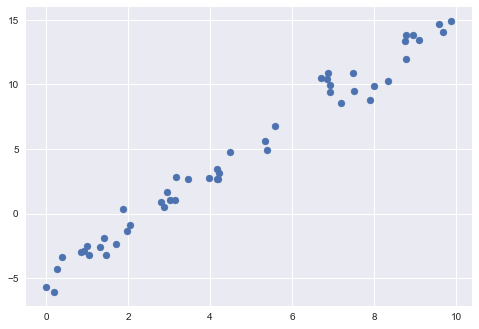

In [3]:
rng = np.random.RandomState(1)
x = 10*rng.rand(50)
y = 2*x - 5 + rng.randn(50)
plt.scatter(x, y);

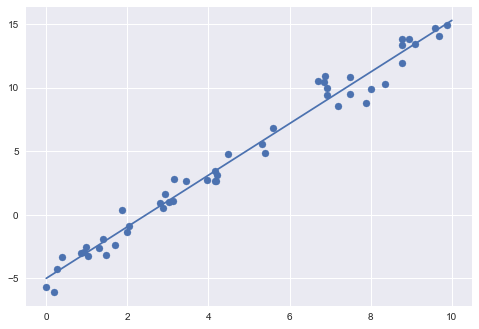

In [4]:
from sklearn.linear_model import LinearRegression
model  = LinearRegression(fit_intercept=True)

model.fit(x[:, np.newaxis], y)

xfit = np.linspace(0, 10, 1000)
yfit = model.predict(xfit[:, np.newaxis])

plt.scatter(x, y)
plt.plot(xfit, yfit);

In [5]:
print("Model slope:     ",  model.coef_[0])
print("Model intercept: ",  model.intercept_)

Model slope:      2.02720881036
Model intercept:  -4.99857708555


The linear regression estimator can also handle other higher dimension;
$$y = a_0 + a_1x_1 + a_2x_2 + \ldots$$

This will be fitting a plane to points in 3-D space

In [6]:
# higher dimension
rng = np.random.RandomState(1)
X = 10* rng.rand(100, 3)
y = 0.5 + np.dot(X, [1.5, -2., 1.]) # y = Ax + b

model.fit(X, y)
print(model.intercept_)
print(model.coef_)

0.5
[ 1.5 -2.   1. ]


### Basis Function Regression
This is a technique used to adapt linea regression to non-linear models.
__What we have effectively done is taken
our one-dimensional x values and projected them into a higher dimension, so that a linear fit can fit more complicated relationships between $x$ and $y$.__

#### Polynomial Basis Function

In [7]:
from sklearn.preprocessing import PolynomialFeatures
x = np.array([2,3,4])
poly = PolynomialFeatures(3, include_bias=False)
poly.fit_transform(x[:, np.newaxis])

array([[  2.,   4.,   8.],
       [  3.,   9.,  27.],
       [  4.,  16.,  64.]])

In [8]:
# using a pipeline for a 7th degree polynomial
from sklearn.pipeline import make_pipeline
poly_model = make_pipeline(PolynomialFeatures(7), LinearRegression())

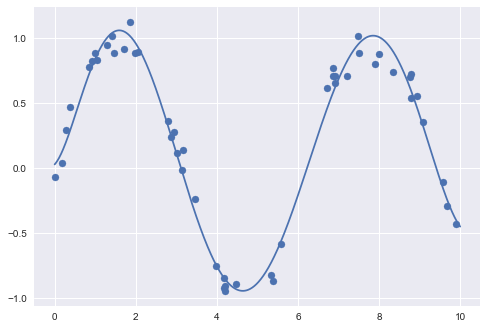

In [9]:
# example of a sine wave with noise
rng = np.random.RandomState(1)
x = 10 * rng.rand(50)
y = np.sin(x) + 0.1 * rng.randn(50)

poly_model.fit(x[:, np.newaxis], y)
yfit = poly_model.predict(xfit[:, np.newaxis])

plt.scatter(x, y)
plt.plot(xfit, yfit);

#### Gaussian Basis Functions

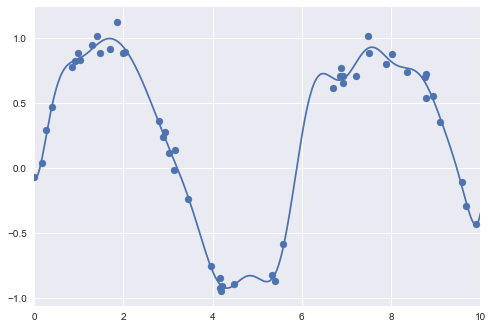

In [10]:
# let's build one as it is not built on Scikit-Learn
from sklearn.base import BaseEstimator, TransformerMixin

class GaussianFeatures(BaseEstimator, TransformerMixin):
    """Uniformly spaced Gaussian features for the one-dimensional input"""
    
    def __init__(self, N, width_factor=2.0):
        self.N = N
        self.width_factor = width_factor
        
        
    @staticmethod
    def _gauss_basis(x, y, width, axis=None):
        arg = (x - y)/width
        return np.exp(-0.5 * np.sum(arg ** 2, axis))
    
    def fit(self, X, y=None):
        # create N centers spread aling the data range
        self.centers_ = np.linspace(X.min(), X.max(), self.N)
        self.width_ = self.width_factor * (self.centers_[1] - self.centers_[0])
        return self
    
    def transform(self, X):
        return self._gauss_basis(X[:, :, np.newaxis], self.centers_,
                                self.width_, axis=1)
    
gauss_model = make_pipeline(GaussianFeatures(20),
                           LinearRegression())

gauss_model.fit(x[:, np.newaxis], y)
yfit = gauss_model.predict(xfit[:, np.newaxis])

plt.scatter(x, y)
plt.plot(xfit, yfit)
plt.xlim(0, 10);
    

### Regularization

__overfitting__

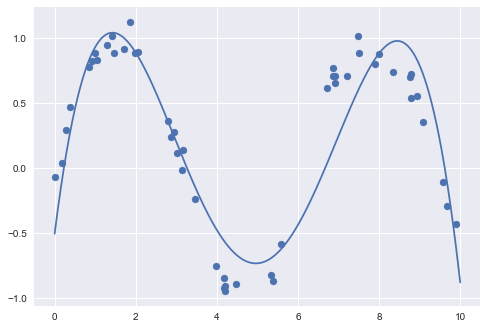

In [11]:
model = make_pipeline(GaussianFeatures(3),
LinearRegression())
model.fit(x[:, np.newaxis], y)
plt.scatter(x, y)
plt.plot(xfit, model.predict(xfit[:, np.newaxis]))

let's see the coefficients of the Gaussina bases with respect to the location

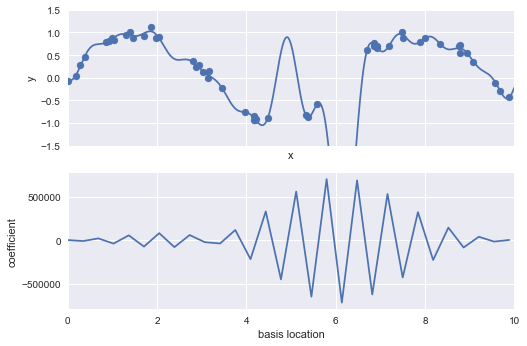

In [12]:
def basis_plot(model, title=None):
    fig, ax = plt.subplots(2, sharex=True)
    model.fit(x[:, np.newaxis], y)
    ax[0].scatter(x, y)
    ax[0].plot(xfit, model.predict(xfit[:, np.newaxis]))
    ax[0].set(xlabel='x', ylabel='y', ylim=(-1.5, 1.5))
    if title:
        ax[0].set_title(title)
    ax[1].plot(model.steps[0][1].centers_,
        model.steps[1][1].coef_)
    ax[1].set(xlabel='basis location',
        ylabel='coefficient',
        xlim=(0, 10))
model = make_pipeline(GaussianFeatures(30), LinearRegression())
basis_plot(model)

__Such behaviour, blowing up and cancelling out is problematic and that is remedied with refularisation__

#### Ridge regression ($L_2$ regularization)
penalizing the sum of squares (2-norms) of the model coefficients; in this case, the penalty on the model fit would be:

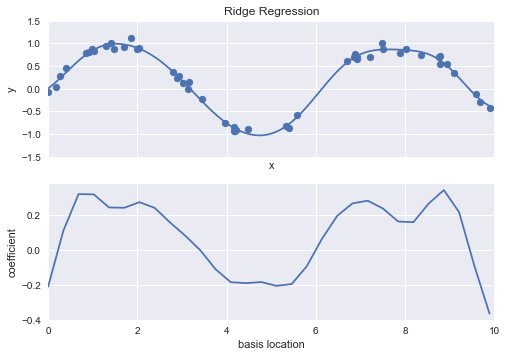

In [13]:
from sklearn.linear_model import Ridge
model = make_pipeline(GaussianFeatures(30), Ridge(alpha=0.1))

basis_plot(model, title='Ridge Regression')

The $\alpha$ parameter essentially serves as a tunable knob controlling the model complexity. $\alpha \rightarrow 0$ gives the original result while $\alpha \rightarrow \infty$ suppresses all the co-efficients. It is an addition to the cost hence it's effect.

#### Lasso regularization $\displaystyle{(L_1)}$
penalizing the sum of absolute values (1-norms) of regression coefficients:

__Though this is conceptually very similar to ridge regression, the results can differ surprisingly: for example, due to geometric reasons lasso regression tends to favor sparse models where possible; that is, it preferentially sets model coefficients to exactly zero.__

C:\Users\Aroogz\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


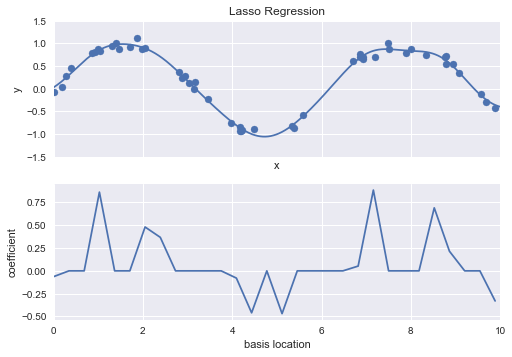

In [14]:
from sklearn.linear_model import Lasso
model = make_pipeline(GaussianFeatures(30), Lasso(alpha=0.001))

basis_plot(model, title='Lasso Regression')

*With the lasso regression penalty, the majority of the coefficients are exactly zero, with the functional behavior being modeled by a small subset of the available basis functions. As with ridge regularization, the α parameter tunes the strength of the penalty, and should be determined via, for example, cross-validation*

### Example: Predicting Bicycle Traffic Data

In [115]:
counts = pd.read_csv('../Data/FremontBridge.csv', index_col='Date', parse_dates=True)
weather = pd.read_csv('../Data/BicycleWeather.csv', index_col='DATE', parse_dates=True)
counts.head(2)

,Fremont Bridge West Sidewalk,Fremont Bridge East Sidewalk
Date,,
2012-10-03 00:00:00,4.0,9.0
2012-10-03 01:00:00,4.0,6.0


In [116]:
weather.tail(1)

,STATION,STATION_NAME,PRCP,SNWD,SNOW,TMAX,TMIN,AWND,WDF2,WDF5,...,WT17,WT05,WT02,WT22,WT04,WT13,WT16,WT08,WT18,WT03
DATE,,,,,,,,,,,,,,,,,,,,,
2015-09-01,GHCND:USW00024233,SEATTLE TACOMA INTERNATIONAL AIRPORT WA US,58,0,0,194,139,-9999,-9999,-9999,...,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999


In [117]:
daily = counts.resample('d').sum()
daily['Total'] = daily.sum(axis=1)
daily = daily[['Total']]
daily.head()

,Total
Date,
2012-10-03,3521.0
2012-10-04,3475.0
2012-10-05,3148.0
2012-10-06,2006.0
2012-10-07,2142.0


*including a the days as variable to account for the effects.. we use binary columns*

In [118]:
days = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
for i in range(7):
    daily[days[i]] = (daily.index.dayofweek == i).astype(float)

In [119]:
daily.tail(3)

,Total,Mon,Tue,Wed,Thu,Fri,Sat,Sun
Date,,,,,,,,
2017-07-29,2435.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2017-07-30,2219.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2017-07-31,4922.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


*We might expect riders to behave differently on holidays so we add indicators for this*

In [120]:
from pandas.tseries.holiday import USFederalHolidayCalendar
cal = USFederalHolidayCalendar()
holidays = cal.holidays('2012', '2017')
daily = daily.join(pd.Series(1, index=holidays, name='holiday'))
daily['holiday'].fillna(0, inplace=True)

We also expect that hours of daylight may have some effect

In [121]:
daily.tail()

,Total,Mon,Tue,Wed,Thu,Fri,Sat,Sun,holiday
Date,,,,,,,,,
2017-07-27,3980.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2017-07-28,4311.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2017-07-29,2435.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2017-07-30,2219.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2017-07-31,4922.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


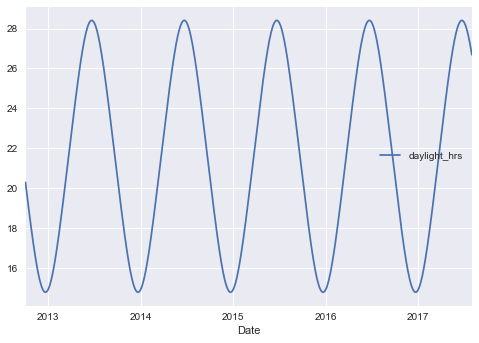

In [122]:
def hours_of_daylight(date, axis=23.44, latitude=47.61):
    """Compute the hours of daylight for the given date using 
    standard astronomical calculation"""
    days = (date -  pd.datetime(2000, 12,21)).days
    m = (1. - np.tan(np.radians(latitude))
        * np.tan(np.radians(axis) * np.cos(days*2*np.pi/365.25)))
    return 24. * np.degrees(np.arccos(1-np.clip(m, 0, 2)))/100.

daily['daylight_hrs'] = list(map(hours_of_daylight, daily.index))
daily[['daylight_hrs']].plot();

In [123]:
daily.tail(3)

,Total,Mon,Tue,Wed,Thu,Fri,Sat,Sun,holiday,daylight_hrs
Date,,,,,,,,,,
2017-07-29,2435.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,26.842710
2017-07-30,2219.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,26.765654
2017-07-31,4922.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,26.687273


*let's add average temperature and total precipitation to the data*

In [124]:
weather['TMIN'] /= 10
weather['TMAX'] /= 10
weather['Temp (C)'] = 0.5 * (weather['TMIN'] + weather['TMAX'])

# precip is in 1/10 mm; converting to inches
weather['PRCP'] /= 254
weather['dry day'] = (weather['PRCP'] == 0).astype(int)

daily = daily.join(weather[['PRCP', 'Temp (C)', 'dry day']], how='inner')

*including a days counter increasing from day 1*

In [125]:
daily['annual'] = (daily.index - daily.index[0]).days / 365
daily.tail(3)

,Total,Mon,Tue,Wed,Thu,Fri,Sat,Sun,holiday,daylight_hrs,PRCP,Temp (C),dry day,annual
2015-08-30,1213.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,23.950100,0.401575,16.40,0,2.906849
2015-08-31,2823.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,23.847843,0.000000,17.50,1,2.909589
2015-09-01,2876.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,23.745230,0.228346,16.65,0,2.912329


In [126]:
# select columns for features
column_names =['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun', 'holiday',
'daylight_hrs', 'PRCP', 'dry day', 'Temp (C)', 'annual']
X = daily[column_names]
y = daily['Total']

model = LinearRegression(fit_intercept=False) # because the flags essentially 
# operate as their own day-specific intercept (MKR - more knowledge required)
model.fit(X,  y)
daily['predicted'] = model.predict(X)

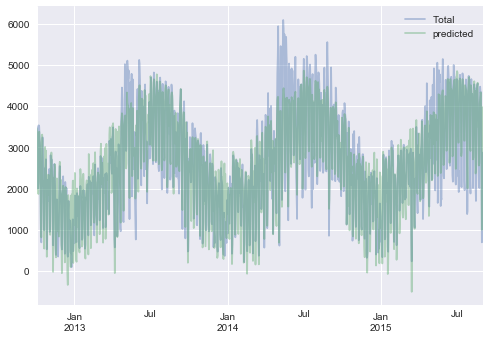

In [127]:
daily[['Total', 'predicted']].plot(alpha=0.4)

In [129]:
params = pd.Series(model.coef_, X.columns)
params

Mon              504.882756
Tue              610.233936
Wed              592.673642
Thu              482.358115
Fri              177.980345
Sat            -1103.301710
Sun            -1133.567246
holiday        -1187.401381
daylight_hrs      71.584173
PRCP            -664.834882
dry day          547.698592
Temp (C)          65.162791
annual            26.942713
dtype: float64

__it is important to know the uncertainties for interpreting the values (sort of like how they swing)__

In [172]:
from sklearn.utils import resample
np.random.seed(1)
err = np.std([model.fit(*resample(X, y)).coef_ for i in range(1000)], axis=0)

In [173]:
print(pd.DataFrame({'effect': params.round(0),
                   'error': err.round(0)}))

              effect  error
Mon            505.0   86.0
Tue            610.0   83.0
Wed            593.0   83.0
Thu            482.0   85.0
Fri            178.0   81.0
Sat          -1103.0   80.0
Sun          -1134.0   83.0
holiday      -1187.0  163.0
daylight_hrs    72.0    5.0
PRCP          -665.0   62.0
dry day        548.0   33.0
Temp (C)        65.0    4.0
annual          27.0   18.0


__Further Explorations__

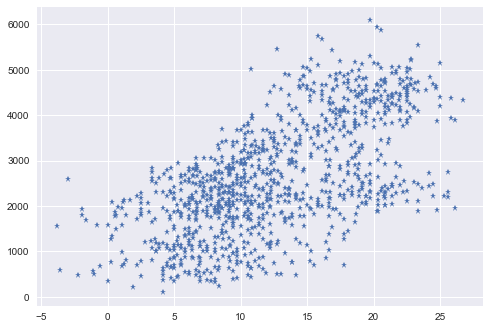

In [178]:
plt.plot(daily['Temp (C)'], daily['Total'], '*', )

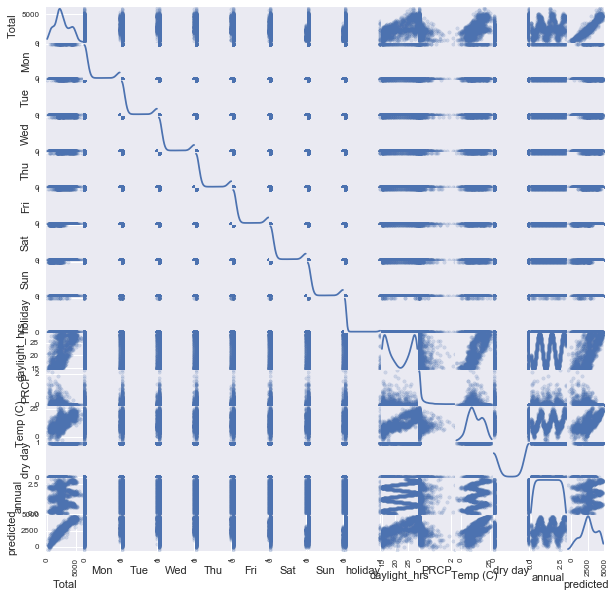

In [184]:
from pandas.tools.plotting import scatter_matrix
scatter_matrix(daily, alpha=0.2, figsize=(10,10), diagonal='kde');